In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

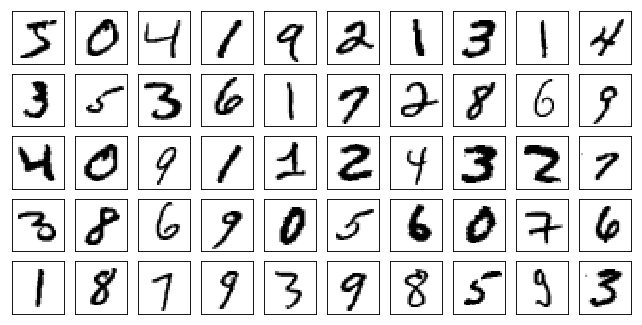

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))            
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        
        return x
    
    def loss(self, output, target, **kwargs):           
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [8]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.327237 drop: 2.327067 plain: 2.398716
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.940708 drop: 2.064648 plain: 2.166881
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.701396 drop: 1.560394 plain: 1.792192
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.356526 drop: 1.018548 plain: 1.202888
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.990829 drop: 0.651022 plain: 0.738635
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.963648 drop: 0.721057 plain: 0.716659
Test set:
bn: Loss: 0.9073	Accuracy: 8850.0/10000 (88%)
drop: Loss: 0.6407	Accuracy: 8445.0/10000 (84%)
plain: Loss: 0.6657	Accuracy: 8510.0/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.997129 drop: 0.727063 plain: 0.745833
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.682070 drop: 0.406315 plain: 0.428687
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.486867 drop: 0.359889 plain: 0.347797
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.545352 drop: 0.371274 plain: 0.34

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.097599 drop: 0.141717 plain: 0.099757
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.087630 drop: 0.099346 plain: 0.125132
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.072654 drop: 0.091802 plain: 0.093036
Test set:
bn: Loss: 0.0702	Accuracy: 9790.0/10000 (98%)
drop: Loss: 0.0874	Accuracy: 9761.0/10000 (98%)
plain: Loss: 0.0818	Accuracy: 9784.0/10000 (98%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.029795 drop: 0.061071 plain: 0.057620
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.078697 drop: 0.104760 plain: 0.097463
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.039354 drop: 0.049134 plain: 0.053806
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.115576 drop: 0.137587 plain: 0.077492
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.049868 drop: 0.040388 plain: 0.031665
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.050742 drop: 0.038363 plain: 0.041651
Test set:
bn: Loss: 0.0659	Accuracy: 9822.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.062874 drop: 0.063268 plain: 0.067614
Test set:
bn: Loss: 0.0466	Accuracy: 9864.0/10000 (99%)
drop: Loss: 0.0584	Accuracy: 9846.0/10000 (98%)
plain: Loss: 0.0562	Accuracy: 9838.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.026951 drop: 0.027114 plain: 0.026477
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.022352 drop: 0.034438 plain: 0.032168
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.020409 drop: 0.032141 plain: 0.032243
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.005217 drop: 0.033979 plain: 0.023460
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.025118 drop: 0.013730 plain: 0.014087
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.044910 drop: 0.037579 plain: 0.045741
Test set:
bn: Loss: 0.0484	Accuracy: 9867.0/10000 (99%)
drop: Loss: 0.0591	Accuracy: 9844.0/10000 (98%)
plain: Loss: 0.0568	Accuracy: 9841.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.018049 drop: 0.011464 plain: 0.011011
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.005484 drop: 0.023479 plain: 0.014725
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.021665 drop: 0.028262 plain: 0.029909
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.003145 drop: 0.008260 plain: 0.005832
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.017277 drop: 0.018855 plain: 0.023037
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.071951 drop: 0.054389 plain: 0.047094
Test set:
bn: Loss: 0.0425	Accuracy: 9877.0/10000 (99%)
drop: Loss: 0.0506	Accuracy: 9862.0/10000 (99%)
plain: Loss: 0.0484	Accuracy: 9858.0/10000 (99%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.003092 drop: 0.005656 plain: 0.006828
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.009749 drop: 0.012060 plain: 0.008190
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.024282 drop: 0.028808 plain: 0.028665
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.031108 drop: 0.047713 plain: 0.055226
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.002226 drop: 0.009

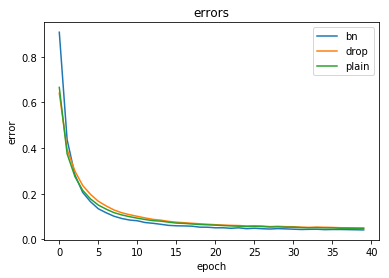

In [11]:
plot_graphs(test_log, 'loss')

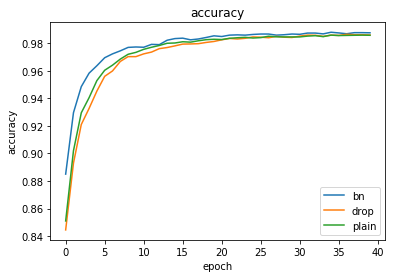

In [12]:
plot_graphs(test_log, 'accuracy')

In [13]:
torch.save(models['bn'], './model_classifier_convs')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Оптимизация изображений

In [8]:
model = torch.load('./model_classifier_convs')

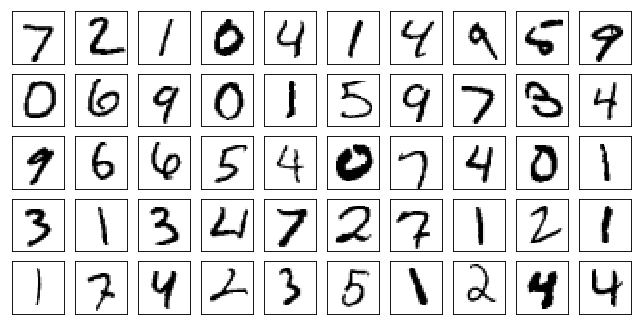

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [9]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

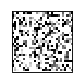

In [37]:
data, _ = next(iter(test_loader))
#img = data[2].view(-1, 1, 28, 28)
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [38]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)    
    target = torch.ones((1), dtype=torch.long) * cl
    #target[cl] = 1
    #target = target.view(1, 10)
    
    loss_stats = []    
    gen_optim = optim.RMSprop([gen_img_par], lr=1e-5, weight_decay=0.)
        
    for i in range(1, 10000001):  
             
        out = model.forward(gen_img_par)        
             
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target)    
        loss.backward()          
        gen_optim.step()
        
        if i % 10000 == 0:    
            print ("Iteration {}: loss={} prediction={}".format(i,loss, out.argmax()))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #1print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 1000:    
                if ls > loss_stats[-2] and ls > loss_stats[-3] and ls > loss_stats[-4] and ls > loss_stats[-5]:
                    print ("Loss is rising .. stop")
                    break

        if i % 100000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
       
   
                        
    return gen_img_par, loss_stats    

Iteration 10000: loss=1.4190750122070312 prediction=7
Iteration 20000: loss=0.016383638605475426 prediction=2
Iteration 30000: loss=0.00019920573686249554 prediction=2
Iteration 40000: loss=4.376486685941927e-06 prediction=2
Iteration 50000: loss=1.9127993766687723e-07 prediction=2
Iteration 60000: loss=4.925396979160723e-08 prediction=2
Iteration 70000: loss=2.7150640846684837e-08 prediction=2
Iteration 80000: loss=2.2873205551832143e-08 prediction=2
Iteration 90000: loss=1.96801277496661e-08 prediction=2
Iteration 100000: loss=1.7196942536656934e-08 prediction=2


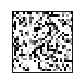

Iteration 110000: loss=1.5280901877190445e-08 prediction=2
Iteration 120000: loss=1.3731133563510411e-08 prediction=2
Iteration 130000: loss=1.2464502319176063e-08 prediction=2
Iteration 140000: loss=1.1427671253727567e-08 prediction=2
Iteration 150000: loss=1.0564351171638009e-08 prediction=2
Iteration 160000: loss=9.843049042501661e-09 prediction=2
Iteration 170000: loss=9.230612718624798e-09 prediction=2
Iteration 180000: loss=8.692655484310308e-09 prediction=2
Iteration 190000: loss=8.228793646480881e-09 prediction=2
Iteration 200000: loss=7.825525116800236e-09 prediction=2


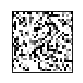

Iteration 210000: loss=7.4605566169339e-09 prediction=2
Iteration 220000: loss=7.1344334884315685e-09 prediction=2
Iteration 230000: loss=6.844906863534561e-09 prediction=2
Iteration 240000: loss=6.5914367297637e-09 prediction=2
Iteration 250000: loss=6.360735937960271e-09 prediction=2
Iteration 260000: loss=6.149539544253457e-09 prediction=2
Iteration 270000: loss=5.951754644684115e-09 prediction=2
Iteration 280000: loss=5.769688726786626e-09 prediction=2
Iteration 290000: loss=5.600888641765778e-09 prediction=2
Iteration 300000: loss=5.446826989441433e-09 prediction=2


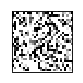

Iteration 310000: loss=5.3042352732290965e-09 prediction=2
Iteration 320000: loss=5.186924667555104e-09 prediction=2
Iteration 330000: loss=5.076939757486798e-09 prediction=2
Iteration 340000: loss=4.974442191496564e-09 prediction=2
Iteration 350000: loss=4.877669823599717e-09 prediction=2
Iteration 360000: loss=4.786876672824292e-09 prediction=2
Iteration 370000: loss=4.700050126871247e-09 prediction=2
Iteration 380000: loss=4.6163144418187585e-09 prediction=2
Iteration 390000: loss=4.535655406812111e-09 prediction=2
Iteration 400000: loss=4.458586388977892e-09 prediction=2


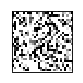

Iteration 410000: loss=4.38617675513342e-09 prediction=2
Iteration 420000: loss=4.317538326858994e-09 prediction=2
Iteration 430000: loss=4.251429430723874e-09 prediction=2
Iteration 440000: loss=4.188716928865688e-09 prediction=2
Iteration 450000: loss=4.130269459778901e-09 prediction=2
Iteration 460000: loss=4.073203996313168e-09 prediction=2
Iteration 470000: loss=4.0172221105194694e-09 prediction=2
Iteration 480000: loss=3.962625783060503e-09 prediction=2
Iteration 490000: loss=3.910274770646538e-09 prediction=2
Iteration 500000: loss=3.859193853372744e-09 prediction=2


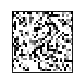

Iteration 510000: loss=3.810013637917109e-09 prediction=2
Iteration 520000: loss=3.762639977367144e-09 prediction=2
Iteration 530000: loss=3.7178971012963302e-09 prediction=2
Iteration 540000: loss=3.67515795574036e-09 prediction=2
Iteration 550000: loss=3.633541467706891e-09 prediction=2
Iteration 560000: loss=3.5920386665111437e-09 prediction=2
Iteration 570000: loss=3.5515235197181028e-09 prediction=2
Iteration 580000: loss=3.5127154518477255e-09 prediction=2
Iteration 590000: loss=3.4747600352602603e-09 prediction=2
Iteration 600000: loss=3.437842011067005e-09 prediction=2


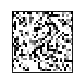

Iteration 610000: loss=3.4017535455177494e-09 prediction=2
Iteration 620000: loss=3.3666438525870035e-09 prediction=2
Iteration 630000: loss=3.332344178375024e-09 prediction=2
Iteration 640000: loss=3.2987585996124835e-09 prediction=2
Iteration 650000: loss=3.2658853399425425e-09 prediction=2
Iteration 660000: loss=3.233854073414477e-09 prediction=2
Iteration 670000: loss=3.202897502774249e-09 prediction=2
Iteration 680000: loss=3.172864637690509e-09 prediction=2
Iteration 690000: loss=3.1433931013680194e-09 prediction=2
Iteration 700000: loss=3.1146427659223264e-09 prediction=2


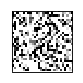

Iteration 710000: loss=3.086517708084102e-09 prediction=2
Iteration 720000: loss=3.0587710142526703e-09 prediction=2
Iteration 730000: loss=3.0313529464365274e-09 prediction=2
Iteration 740000: loss=3.004668513995057e-09 prediction=2
Iteration 750000: loss=2.9783571164898603e-09 prediction=2
Iteration 760000: loss=2.9524827027671563e-09 prediction=2
Iteration 770000: loss=2.9269777712670475e-09 prediction=2
Iteration 780000: loss=2.9019595615409344e-09 prediction=2
Iteration 790000: loss=2.8775826166338447e-09 prediction=2
Iteration 800000: loss=2.853555614024117e-09 prediction=2


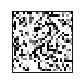

Iteration 810000: loss=2.8297790777287446e-09 prediction=2
Iteration 820000: loss=2.8064643942116163e-09 prediction=2
Iteration 830000: loss=2.7835742599791047e-09 prediction=2
Iteration 840000: loss=2.7614710518264474e-09 prediction=2
Iteration 850000: loss=2.739731996825867e-09 prediction=2
Iteration 860000: loss=2.7183997275415095e-09 prediction=2
Iteration 870000: loss=2.6974298350523895e-09 prediction=2
Iteration 880000: loss=2.6768134375743102e-09 prediction=2
Iteration 890000: loss=2.65673349986173e-09 prediction=2
Iteration 900000: loss=2.636648233078631e-09 prediction=2


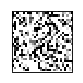

Iteration 910000: loss=2.616822314394085e-09 prediction=2
Iteration 920000: loss=2.597202453102909e-09 prediction=2
Iteration 930000: loss=2.578211422132881e-09 prediction=2
Iteration 940000: loss=2.5594832919750843e-09 prediction=2
Iteration 950000: loss=2.541289845225947e-09 prediction=2
Iteration 960000: loss=2.523462327985726e-09 prediction=2
Iteration 970000: loss=2.506052254602764e-09 prediction=2
Iteration 980000: loss=2.488841133185815e-09 prediction=2
Iteration 990000: loss=2.4719568614273157e-09 prediction=2
Iteration 1000000: loss=2.455287528846384e-09 prediction=2


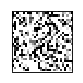

Iteration 1010000: loss=2.4387976083062313e-09 prediction=2
Iteration 1020000: loss=2.4225297323710038e-09 prediction=2
Iteration 1030000: loss=2.4064750192565043e-09 prediction=2
Iteration 1040000: loss=2.3905464274776023e-09 prediction=2
Iteration 1050000: loss=2.3750530431243533e-09 prediction=2
Iteration 1060000: loss=2.359859863076963e-09 prediction=2
Iteration 1070000: loss=2.3450308361816496e-09 prediction=2
Iteration 1080000: loss=2.330541093442662e-09 prediction=2
Iteration 1090000: loss=2.3164794527019694e-09 prediction=2
Iteration 1100000: loss=2.3030004570046003e-09 prediction=2


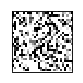

Iteration 1110000: loss=2.2898341001109657e-09 prediction=2
Iteration 1120000: loss=2.2767849827687314e-09 prediction=2
Iteration 1130000: loss=2.2638211305547884e-09 prediction=2
Iteration 1140000: loss=2.250869712838721e-09 prediction=2
Iteration 1150000: loss=2.2381332343002214e-09 prediction=2
Iteration 1160000: loss=2.225664985644471e-09 prediction=2
Iteration 1170000: loss=2.213527139360849e-09 prediction=2
Iteration 1180000: loss=2.201508308985467e-09 prediction=2
Iteration 1190000: loss=2.189596060020449e-09 prediction=2
Iteration 1200000: loss=2.177817037818386e-09 prediction=2


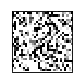

Iteration 1210000: loss=2.166482104826173e-09 prediction=2
Iteration 1220000: loss=2.1553905327209577e-09 prediction=2
Iteration 1230000: loss=2.1444677145154856e-09 prediction=2
Iteration 1240000: loss=2.13388062775266e-09 prediction=2
Iteration 1250000: loss=2.1236488123577146e-09 prediction=2
Iteration 1260000: loss=2.1136923322728762e-09 prediction=2
Iteration 1270000: loss=2.1038992770172626e-09 prediction=2
Iteration 1280000: loss=2.0944312950632593e-09 prediction=2
Iteration 1290000: loss=2.0851960158552174e-09 prediction=2
Iteration 1300000: loss=2.0760015928544817e-09 prediction=2


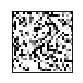

Iteration 1310000: loss=2.0669208566914676e-09 prediction=2
Iteration 1320000: loss=2.0579058457315114e-09 prediction=2
Iteration 1330000: loss=2.04902406153451e-09 prediction=2
Iteration 1340000: loss=2.0401493827648665e-09 prediction=2
Iteration 1350000: loss=2.031239176858435e-09 prediction=2
Iteration 1360000: loss=2.0223840380140246e-09 prediction=2
Iteration 1370000: loss=2.0135750844474387e-09 prediction=2
Iteration 1380000: loss=2.004881594075414e-09 prediction=2
Iteration 1390000: loss=1.9961596819939587e-09 prediction=2
Iteration 1400000: loss=1.987519482327116e-09 prediction=2


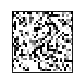

Iteration 1410000: loss=1.9790462602031766e-09 prediction=2
Iteration 1420000: loss=1.970725804767426e-09 prediction=2
Iteration 1430000: loss=1.96247995631893e-09 prediction=2
Iteration 1440000: loss=1.9544987850395046e-09 prediction=2
Iteration 1450000: loss=1.9465975498178523e-09 prediction=2
Iteration 1460000: loss=1.9388863847780158e-09 prediction=2
Iteration 1470000: loss=1.9312818011485433e-09 prediction=2
Iteration 1480000: loss=1.9236754411622314e-09 prediction=2
Iteration 1490000: loss=1.9161667808020866e-09 prediction=2
Iteration 1500000: loss=1.9088606251216333e-09 prediction=2


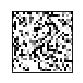

Iteration 1510000: loss=1.901678814419938e-09 prediction=2
Iteration 1520000: loss=1.894759904530474e-09 prediction=2
Iteration 1530000: loss=1.8882868602076996e-09 prediction=2
Iteration 1540000: loss=1.882039413203529e-09 prediction=2
Iteration 1550000: loss=1.8758647968297737e-09 prediction=2
Iteration 1560000: loss=1.8697523529453974e-09 prediction=2
Iteration 1570000: loss=1.863737608687188e-09 prediction=2
Iteration 1580000: loss=1.8577868132751973e-09 prediction=2
Iteration 1590000: loss=1.8519639155556433e-09 prediction=2
Iteration 1600000: loss=1.846281350026402e-09 prediction=2


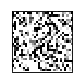

Iteration 1610000: loss=1.8406964841233275e-09 prediction=2
Iteration 1620000: loss=1.835257279481084e-09 prediction=2
Iteration 1630000: loss=1.8298642601166648e-09 prediction=2
Iteration 1640000: loss=1.8246790745024555e-09 prediction=2
Iteration 1650000: loss=1.819612904796486e-09 prediction=2
Iteration 1660000: loss=1.8145502878041952e-09 prediction=2
Iteration 1670000: loss=1.8095018816666197e-09 prediction=2
Iteration 1680000: loss=1.804528082516299e-09 prediction=2
Iteration 1690000: loss=1.7996182322121967e-09 prediction=2
Iteration 1700000: loss=1.7948647013099617e-09 prediction=2


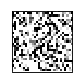

Iteration 1710000: loss=1.790157355685551e-09 prediction=2
Iteration 1720000: loss=1.7854890899116072e-09 prediction=2
Iteration 1730000: loss=1.7809274055480273e-09 prediction=2
Iteration 1740000: loss=1.7763976956075567e-09 prediction=2
Iteration 1750000: loss=1.7718644329534072e-09 prediction=2
Iteration 1760000: loss=1.767398671859155e-09 prediction=2
Iteration 1770000: loss=1.762964885188012e-09 prediction=2
Iteration 1780000: loss=1.758566625653657e-09 prediction=2
Iteration 1790000: loss=1.7542003405424111e-09 prediction=2
Iteration 1800000: loss=1.7499850457625143e-09 prediction=2


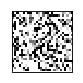

Iteration 1810000: loss=1.7457786327668146e-09 prediction=2
Iteration 1820000: loss=1.74158643062583e-09 prediction=2
Iteration 1830000: loss=1.737285870717642e-09 prediction=2
Iteration 1840000: loss=1.7329799817389357e-09 prediction=2
Iteration 1850000: loss=1.728649223764478e-09 prediction=2
Iteration 1860000: loss=1.724366427424684e-09 prediction=2
Iteration 1870000: loss=1.720119158221678e-09 prediction=2
Iteration 1880000: loss=1.7159624832174813e-09 prediction=2
Iteration 1890000: loss=1.7118164663543212e-09 prediction=2
Iteration 1900000: loss=1.7076597913501246e-09 prediction=2


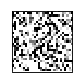

Iteration 1910000: loss=1.7035226562711614e-09 prediction=2
Iteration 1920000: loss=1.6994903262457228e-09 prediction=2
Iteration 1930000: loss=1.6954473380792479e-09 prediction=2
Iteration 1940000: loss=1.6914381006927215e-09 prediction=2
Iteration 1950000: loss=1.68750347029345e-09 prediction=2
Iteration 1960000: loss=1.6835741689646966e-09 prediction=2
Iteration 1970000: loss=1.6796608548474978e-09 prediction=2
Iteration 1980000: loss=1.6757049081661535e-09 prediction=2
Iteration 1990000: loss=1.671779159551079e-09 prediction=2
Iteration 2000000: loss=1.6678765035749166e-09 prediction=2


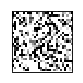

Iteration 2010000: loss=1.6639667421713966e-09 prediction=2
Iteration 2020000: loss=1.660103166045701e-09 prediction=2
Iteration 2030000: loss=1.656259129845239e-09 prediction=2
Iteration 2040000: loss=1.6524843715615134e-09 prediction=2
Iteration 2050000: loss=1.6487380349872183e-09 prediction=2
Iteration 2060000: loss=1.6450591999728204e-09 prediction=2
Iteration 2070000: loss=1.6414123393815316e-09 prediction=2
Iteration 2080000: loss=1.6377992295701915e-09 prediction=2
Iteration 2090000: loss=1.6341950015430484e-09 prediction=2
Iteration 2100000: loss=1.6305907735159053e-09 prediction=2


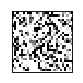

Iteration 2110000: loss=1.627007861770835e-09 prediction=2
Iteration 2120000: loss=1.6234285027394435e-09 prediction=2
Iteration 2130000: loss=1.6198651309196066e-09 prediction=2
Iteration 2140000: loss=1.616303535456609e-09 prediction=2
Iteration 2150000: loss=1.6127650326325238e-09 prediction=2
Iteration 2160000: loss=1.6092531751610295e-09 prediction=2
Iteration 2170000: loss=1.6057750684694838e-09 prediction=2
Iteration 2180000: loss=1.602327159844208e-09 prediction=2
Iteration 2190000: loss=1.598950305492508e-09 prediction=2
Iteration 2200000: loss=1.5956196364186326e-09 prediction=2


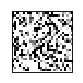

Iteration 2210000: loss=1.5923973251119605e-09 prediction=2
Iteration 2220000: loss=1.5892851479293313e-09 prediction=2
Iteration 2230000: loss=1.5862244850950447e-09 prediction=2
Iteration 2240000: loss=1.5831869148996702e-09 prediction=2
Iteration 2250000: loss=1.5801742137000474e-09 prediction=2
Iteration 2260000: loss=1.5771863814961762e-09 prediction=2
Iteration 2270000: loss=1.5742234182880566e-09 prediction=2
Iteration 2280000: loss=1.571287100432528e-09 prediction=2
Iteration 2290000: loss=1.5683827570001085e-09 prediction=2
Iteration 2300000: loss=1.5655032825634407e-09 prediction=2


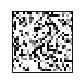

Iteration 2310000: loss=1.5626735461182761e-09 prediction=2
Iteration 2320000: loss=1.5598651259551843e-09 prediction=2
Iteration 2330000: loss=1.5570655875762895e-09 prediction=2
Iteration 2340000: loss=1.554244732915322e-09 prediction=2
Iteration 2350000: loss=1.5514274309680331e-09 prediction=2
Iteration 2360000: loss=1.5486651960827658e-09 prediction=2
Iteration 2370000: loss=1.5459757918279138e-09 prediction=2
Iteration 2380000: loss=1.5433396782782438e-09 prediction=2
Iteration 2390000: loss=1.540771066288471e-09 prediction=2
Iteration 2400000: loss=1.538241534149165e-09 prediction=2


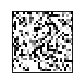

Iteration 2410000: loss=1.535751081860326e-09 prediction=2
Iteration 2420000: loss=1.5332588532146474e-09 prediction=2
Iteration 2430000: loss=1.5307755063531658e-09 prediction=2
Iteration 2440000: loss=1.5282903831348449e-09 prediction=2
Iteration 2450000: loss=1.5258088126302027e-09 prediction=2
Iteration 2460000: loss=1.5233361239097576e-09 prediction=2
Iteration 2470000: loss=1.5208865278282246e-09 prediction=2
Iteration 2480000: loss=1.518468906169801e-09 prediction=2
Iteration 2490000: loss=1.5160512845113772e-09 prediction=2
Iteration 2500000: loss=1.5136922826286536e-09 prediction=2


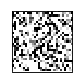

Iteration 2510000: loss=1.511354597028003e-09 prediction=2
Iteration 2520000: loss=1.5090755312030524e-09 prediction=2
Iteration 2530000: loss=1.5068497560832839e-09 prediction=2
Iteration 2540000: loss=1.5046559553866246e-09 prediction=2
Iteration 2550000: loss=1.5024710364741622e-09 prediction=2
Iteration 2560000: loss=1.5002914466322181e-09 prediction=2
Iteration 2570000: loss=1.4981100804334346e-09 prediction=2
Iteration 2580000: loss=1.4959784522261543e-09 prediction=2
Iteration 2590000: loss=1.4938876802261802e-09 prediction=2
Iteration 2600000: loss=1.491782697371491e-09 prediction=2


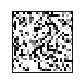

Iteration 2610000: loss=1.4896670563757652e-09 prediction=2
Iteration 2620000: loss=1.4875674025915941e-09 prediction=2
Iteration 2630000: loss=1.4854961705168535e-09 prediction=2
Iteration 2640000: loss=1.4834000694463612e-09 prediction=2
Iteration 2650000: loss=1.4812080451065412e-09 prediction=2
Iteration 2660000: loss=1.4790568769740275e-09 prediction=2
Iteration 2670000: loss=1.4769234724099078e-09 prediction=2
Iteration 2680000: loss=1.4748060550573427e-09 prediction=2
Iteration 2690000: loss=1.4727135067005293e-09 prediction=2
Iteration 2700000: loss=1.4706813544762554e-09 prediction=2


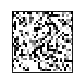

Iteration 2710000: loss=1.4686758476045725e-09 prediction=2
Iteration 2720000: loss=1.4666863279444442e-09 prediction=2
Iteration 2730000: loss=1.46471457185271e-09 prediction=2
Iteration 2740000: loss=1.4627339339767786e-09 prediction=2
Iteration 2750000: loss=1.4607355325324534e-09 prediction=2
Iteration 2760000: loss=1.4587584473702009e-09 prediction=2
Iteration 2770000: loss=1.4568133366310576e-09 prediction=2
Iteration 2780000: loss=1.4548895421739871e-09 prediction=2
Iteration 2790000: loss=1.4529071279412165e-09 prediction=2
Iteration 2800000: loss=1.450930042778964e-09 prediction=2


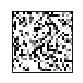

Iteration 2810000: loss=1.448972497541945e-09 prediction=2
Iteration 2820000: loss=1.4470149523049258e-09 prediction=2
Iteration 2830000: loss=1.445053854354228e-09 prediction=2
Iteration 2840000: loss=1.4430892036898513e-09 prediction=2
Iteration 2850000: loss=1.4411600801622626e-09 prediction=2
Iteration 2860000: loss=1.439222074850477e-09 prediction=2
Iteration 2870000: loss=1.437314267604961e-09 prediction=2
Iteration 2880000: loss=1.4354029076457664e-09 prediction=2
Iteration 2890000: loss=1.4334933240434111e-09 prediction=2
Iteration 2900000: loss=1.4315855167978953e-09 prediction=2


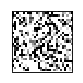

Iteration 2910000: loss=1.4296990258344522e-09 prediction=2
Iteration 2920000: loss=1.4278764837172275e-09 prediction=2
Iteration 2930000: loss=1.4260805869525939e-09 prediction=2
Iteration 2940000: loss=1.4242953483289966e-09 prediction=2
Iteration 2950000: loss=1.4225491895558662e-09 prediction=2
Iteration 2960000: loss=1.4207888199280205e-09 prediction=2
Iteration 2970000: loss=1.4190284503001749e-09 prediction=2
Iteration 2980000: loss=1.4172396589628988e-09 prediction=2
Iteration 2990000: loss=1.4154508676256228e-09 prediction=2
Iteration 3000000: loss=1.4136443127199527e-09 prediction=2


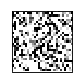

Iteration 3010000: loss=1.411839534171122e-09 prediction=2
Iteration 3020000: loss=1.4100454137633278e-09 prediction=2
Iteration 3030000: loss=1.4082495169986942e-09 prediction=2
Iteration 3040000: loss=1.406482041943491e-09 prediction=2
Iteration 3050000: loss=1.404787397518703e-09 prediction=2
Iteration 3060000: loss=1.4031211748033456e-09 prediction=2
Iteration 3070000: loss=1.4014389648764336e-09 prediction=2
Iteration 3080000: loss=1.3997727421610762e-09 prediction=2
Iteration 3090000: loss=1.3982113244992433e-09 prediction=2
Iteration 3100000: loss=1.396758264604614e-09 prediction=2


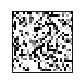

Iteration 3110000: loss=1.3953318500625755e-09 prediction=2
Iteration 3120000: loss=1.3939018828068583e-09 prediction=2
Iteration 3130000: loss=1.3924790209784987e-09 prediction=2
Iteration 3140000: loss=1.3910401719385845e-09 prediction=2
Iteration 3150000: loss=1.389599546541831e-09 prediction=2
Iteration 3160000: loss=1.3881624738587561e-09 prediction=2
Iteration 3170000: loss=1.3866721104704993e-09 prediction=2
Iteration 3180000: loss=1.3851781943685637e-09 prediction=2
Iteration 3190000: loss=1.383705594548701e-09 prediction=2
Iteration 3200000: loss=1.3822436528698745e-09 prediction=2


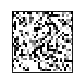

Iteration 3210000: loss=1.3807923693320845e-09 prediction=2
Iteration 3220000: loss=1.3793446385079733e-09 prediction=2
Iteration 3230000: loss=1.377905789468059e-09 prediction=2
Iteration 3240000: loss=1.3764491768597509e-09 prediction=2
Iteration 3250000: loss=1.375003222392479e-09 prediction=2
Iteration 3260000: loss=1.373560820638886e-09 prediction=2
Iteration 3270000: loss=1.37212730066949e-09 prediction=2
Iteration 3280000: loss=1.370684898915897e-09 prediction=2
Iteration 3290000: loss=1.369251378946501e-09 prediction=2
Iteration 3300000: loss=1.367826740761302e-09 prediction=2


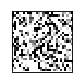

Iteration 3310000: loss=1.3663790099371909e-09 prediction=2
Iteration 3320000: loss=1.3649525953951525e-09 prediction=2
Iteration 3330000: loss=1.3635315099236323e-09 prediction=2
Iteration 3340000: loss=1.3621086480952727e-09 prediction=2
Iteration 3350000: loss=1.3607266424742193e-09 prediction=2
Iteration 3360000: loss=1.3594263492677783e-09 prediction=2
Iteration 3370000: loss=1.358174017696001e-09 prediction=2
Iteration 3380000: loss=1.356912804340027e-09 prediction=2
Iteration 3390000: loss=1.3556284983451405e-09 prediction=2
Iteration 3400000: loss=1.3543246524250208e-09 prediction=2


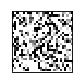

Iteration 3410000: loss=1.3530243592185798e-09 prediction=2
Iteration 3420000: loss=1.3517276187258176e-09 prediction=2
Iteration 3430000: loss=1.3504486418014494e-09 prediction=2
Iteration 3440000: loss=1.3491696648770812e-09 prediction=2
Iteration 3450000: loss=1.3478942406663919e-09 prediction=2
Iteration 3460000: loss=1.3466134873851843e-09 prediction=2
Iteration 3470000: loss=1.345334510460816e-09 prediction=2
Iteration 3480000: loss=1.3440963897437541e-09 prediction=2
Iteration 3490000: loss=1.3428902434498013e-09 prediction=2
Iteration 3500000: loss=1.3416734390148122e-09 prediction=2


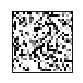

Iteration 3510000: loss=1.3404442000819472e-09 prediction=2
Iteration 3520000: loss=1.3392504882858702e-09 prediction=2
Iteration 3530000: loss=1.338024802066684e-09 prediction=2
Iteration 3540000: loss=1.3367635887107099e-09 prediction=2
Iteration 3550000: loss=1.335463295504269e-09 prediction=2
Iteration 3560000: loss=1.3341310278747187e-09 prediction=2
Iteration 3570000: loss=1.3328236292409201e-09 prediction=2
Iteration 3580000: loss=1.3315339941755155e-09 prediction=2
Iteration 3590000: loss=1.3302567936079868e-09 prediction=2
Iteration 3600000: loss=1.3289866984678156e-09 prediction=2


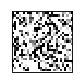

Iteration 3610000: loss=1.327732590539199e-09 prediction=2
Iteration 3620000: loss=1.3264909171084582e-09 prediction=2
Iteration 3630000: loss=1.3252581254619145e-09 prediction=2
Iteration 3640000: loss=1.324035991956407e-09 prediction=2
Iteration 3650000: loss=1.3228227402350967e-09 prediction=2
Iteration 3660000: loss=1.3215686323064801e-09 prediction=2
Iteration 3670000: loss=1.320316300734703e-09 prediction=2
Iteration 3680000: loss=1.319087061801838e-09 prediction=2
Iteration 3690000: loss=1.317857822868973e-09 prediction=2
Iteration 3700000: loss=1.3166268075792686e-09 prediction=2


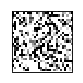

Iteration 3710000: loss=1.315425990355834e-09 prediction=2
Iteration 3720000: loss=1.3142411603439541e-09 prediction=2
Iteration 3730000: loss=1.3130545539752347e-09 prediction=2
Iteration 3740000: loss=1.311875053033873e-09 prediction=2
Iteration 3750000: loss=1.3106937757356718e-09 prediction=2
Iteration 3760000: loss=1.3095249329353464e-09 prediction=2
Iteration 3770000: loss=1.3083507610645029e-09 prediction=2
Iteration 3780000: loss=1.307219221757805e-09 prediction=2
Iteration 3790000: loss=1.3061107750900192e-09 prediction=2
Iteration 3800000: loss=1.305000552065394e-09 prediction=2


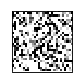

Iteration 3810000: loss=1.3039169743933599e-09 prediction=2
Iteration 3820000: loss=1.3028493839328803e-09 prediction=2
Iteration 3830000: loss=1.301787122542919e-09 prediction=2
Iteration 3840000: loss=1.3006768995182938e-09 prediction=2
Iteration 3850000: loss=1.2995666764936686e-09 prediction=2
Iteration 3860000: loss=1.2984617825395617e-09 prediction=2
Iteration 3870000: loss=1.297362217655973e-09 prediction=2
Iteration 3880000: loss=1.2962537709881872e-09 prediction=2
Iteration 3890000: loss=1.2951471006772408e-09 prediction=2
Iteration 3900000: loss=1.294056417577849e-09 prediction=2


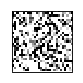

Iteration 3910000: loss=1.2929657344784573e-09 prediction=2
Iteration 3920000: loss=1.2918874858769414e-09 prediction=2
Iteration 3930000: loss=1.2908021318480678e-09 prediction=2
Iteration 3940000: loss=1.2897167778191942e-09 prediction=2
Iteration 3950000: loss=1.2886491873587147e-09 prediction=2
Iteration 3960000: loss=1.2875887023255927e-09 prediction=2
Iteration 3970000: loss=1.2865228882219526e-09 prediction=2
Iteration 3980000: loss=1.2854606268319912e-09 prediction=2
Iteration 3990000: loss=1.2844267871514603e-09 prediction=2
Iteration 4000000: loss=1.2834142637530022e-09 prediction=2


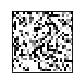

Iteration 4010000: loss=1.2824354911344926e-09 prediction=2
Iteration 4020000: loss=1.281438954947589e-09 prediction=2
Iteration 4030000: loss=1.2804424187606855e-09 prediction=2
Iteration 4040000: loss=1.2794298953622274e-09 prediction=2
Iteration 4050000: loss=1.278412042893251e-09 prediction=2
Iteration 4060000: loss=1.2773924140674353e-09 prediction=2
Iteration 4070000: loss=1.2763958778805318e-09 prediction=2
Iteration 4080000: loss=1.2753957889799494e-09 prediction=2
Iteration 4090000: loss=1.274395700079367e-09 prediction=2
Iteration 4100000: loss=1.2734133747471788e-09 prediction=2


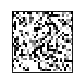

Iteration 4110000: loss=1.2724363784855086e-09 prediction=2
Iteration 4120000: loss=1.2714611585806779e-09 prediction=2
Iteration 4130000: loss=1.2704663987506137e-09 prediction=2
Iteration 4140000: loss=1.2694609807795132e-09 prediction=2
Iteration 4150000: loss=1.2684431283105368e-09 prediction=2
Iteration 4160000: loss=1.2674323812689181e-09 prediction=2
Iteration 4170000: loss=1.2664163051567812e-09 prediction=2
Iteration 4180000: loss=1.265457072463505e-09 prediction=2
Iteration 4190000: loss=1.264476523488156e-09 prediction=2
Iteration 4200000: loss=1.2635332780064346e-09 prediction=2


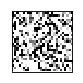

Iteration 4210000: loss=1.2625882561678736e-09 prediction=2
Iteration 4220000: loss=1.2616112599062035e-09 prediction=2
Iteration 4230000: loss=1.2606378163582121e-09 prediction=2
Iteration 4240000: loss=1.2596679255238996e-09 prediction=2
Iteration 4250000: loss=1.2587015874032659e-09 prediction=2
Iteration 4260000: loss=1.2577281438552745e-09 prediction=2
Iteration 4270000: loss=1.2567706875188378e-09 prediction=2
Iteration 4280000: loss=1.2558061257550435e-09 prediction=2
Iteration 4290000: loss=1.2548433403480885e-09 prediction=2
Iteration 4300000: loss=1.25389121308217e-09 prediction=2


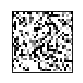

Iteration 4310000: loss=1.2529230986046969e-09 prediction=2
Iteration 4320000: loss=1.2519461023430267e-09 prediction=2
Iteration 4330000: loss=1.250935355301408e-09 prediction=2
Iteration 4340000: loss=1.2499334900439862e-09 prediction=2
Iteration 4350000: loss=1.2489280720728857e-09 prediction=2
Iteration 4360000: loss=1.2479137723175882e-09 prediction=2
Iteration 4370000: loss=1.2468959198486118e-09 prediction=2
Iteration 4380000: loss=1.2458816200933143e-09 prediction=2
Iteration 4390000: loss=1.2448744257653743e-09 prediction=2
Iteration 4400000: loss=1.2438583496532374e-09 prediction=2


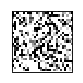

Iteration 4410000: loss=1.2428458262547792e-09 prediction=2
Iteration 4420000: loss=1.2418581718520727e-09 prediction=2
Iteration 4430000: loss=1.2409220317977088e-09 prediction=2
Iteration 4440000: loss=1.2399929971707024e-09 prediction=2
Iteration 4450000: loss=1.2390906078962871e-09 prediction=2
Iteration 4460000: loss=1.2381864422650324e-09 prediction=2
Iteration 4470000: loss=1.2372876057042959e-09 prediction=2
Iteration 4480000: loss=1.2363674528614865e-09 prediction=2
Iteration 4490000: loss=1.235486379869144e-09 prediction=2
Iteration 4500000: loss=1.2346106359473197e-09 prediction=2


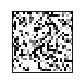

Iteration 4510000: loss=1.2337402210960136e-09 prediction=2
Iteration 4520000: loss=1.232841384535277e-09 prediction=2
Iteration 4530000: loss=1.2319567588292557e-09 prediction=2
Iteration 4540000: loss=1.2310721331232344e-09 prediction=2
Iteration 4550000: loss=1.2301661911351403e-09 prediction=2
Iteration 4560000: loss=1.229254920076528e-09 prediction=2
Iteration 4570000: loss=1.2283436490179156e-09 prediction=2
Iteration 4580000: loss=1.2274341543161427e-09 prediction=2
Iteration 4590000: loss=1.2265175541870121e-09 prediction=2
Iteration 4600000: loss=1.2256418102651878e-09 prediction=2


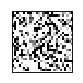

Iteration 4610000: loss=1.2247767244843999e-09 prediction=2
Iteration 4620000: loss=1.2239134150604514e-09 prediction=2
Iteration 4630000: loss=1.2230572110638604e-09 prediction=2
Iteration 4640000: loss=1.2222010070672695e-09 prediction=2
Iteration 4650000: loss=1.221355461211715e-09 prediction=2
Iteration 4660000: loss=1.220508138999321e-09 prediction=2
Iteration 4670000: loss=1.2196768039984818e-09 prediction=2
Iteration 4680000: loss=1.2188454689976425e-09 prediction=2
Iteration 4690000: loss=1.218017686710482e-09 prediction=2
Iteration 4700000: loss=1.2171810226391244e-09 prediction=2


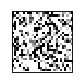

Iteration 4710000: loss=1.2163390294972487e-09 prediction=2
Iteration 4720000: loss=1.2155734196994672e-09 prediction=2
Iteration 4730000: loss=1.2147935990469705e-09 prediction=2
Iteration 4740000: loss=1.2140066729671162e-09 prediction=2
Iteration 4750000: loss=1.2132304050282983e-09 prediction=2
Iteration 4760000: loss=1.2124559134463198e-09 prediction=2
Iteration 4770000: loss=1.2116707637233048e-09 prediction=2
Iteration 4780000: loss=1.2108980484981657e-09 prediction=2
Iteration 4790000: loss=1.2101164514888296e-09 prediction=2
Iteration 4800000: loss=1.2093401835500117e-09 prediction=2


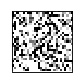

Iteration 4810000: loss=1.2085710210385514e-09 prediction=2
Iteration 4820000: loss=1.2077947530997335e-09 prediction=2
Iteration 4830000: loss=1.2070255905882732e-09 prediction=2
Iteration 4840000: loss=1.2062493226494553e-09 prediction=2
Iteration 4850000: loss=1.2054499620717252e-09 prediction=2
Iteration 4860000: loss=1.2046648123487103e-09 prediction=2
Iteration 4870000: loss=1.2038849916962135e-09 prediction=2
Iteration 4880000: loss=1.2030980656163592e-09 prediction=2
Iteration 4890000: loss=1.2023093631796655e-09 prediction=2
Iteration 4900000: loss=1.2015402006682052e-09 prediction=2


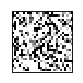

Iteration 4910000: loss=1.2007745908704237e-09 prediction=2
Iteration 4920000: loss=1.2000160864999998e-09 prediction=2
Iteration 4930000: loss=1.1992558057727365e-09 prediction=2
Iteration 4940000: loss=1.198516841327546e-09 prediction=2
Iteration 4950000: loss=1.197776100525516e-09 prediction=2
Iteration 4960000: loss=1.1970353597234862e-09 prediction=2
Iteration 4970000: loss=1.1963035007056533e-09 prediction=2
Iteration 4980000: loss=1.195560983546784e-09 prediction=2
Iteration 4990000: loss=1.1948273481721117e-09 prediction=2
Iteration 5000000: loss=1.1940937127974394e-09 prediction=2


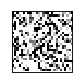

Iteration 5010000: loss=1.19335119563857e-09 prediction=2
Iteration 5020000: loss=1.1926193366207372e-09 prediction=2
Iteration 5030000: loss=1.1918839248892255e-09 prediction=2
Iteration 5040000: loss=1.1911325259461591e-09 prediction=2
Iteration 5050000: loss=1.1903900087872898e-09 prediction=2
Iteration 5060000: loss=1.1896350571305447e-09 prediction=2
Iteration 5070000: loss=1.1888872109011572e-09 prediction=2
Iteration 5080000: loss=1.1881375883149303e-09 prediction=2
Iteration 5090000: loss=1.187386189371864e-09 prediction=2
Iteration 5100000: loss=1.1866259086446007e-09 prediction=2


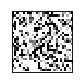

Iteration 5110000: loss=1.185872733344695e-09 prediction=2
Iteration 5120000: loss=1.185114228974271e-09 prediction=2
Iteration 5130000: loss=1.1843095393260228e-09 prediction=2
Iteration 5140000: loss=1.1834124791221257e-09 prediction=2
Iteration 5150000: loss=1.1825225243455861e-09 prediction=2
Iteration 5160000: loss=1.1816201350711708e-09 prediction=2
Iteration 5170000: loss=1.1807141930830767e-09 prediction=2
Iteration 5180000: loss=1.1798153565223402e-09 prediction=2
Iteration 5190000: loss=1.1789129672479248e-09 prediction=2
Iteration 5200000: loss=1.178021236114546e-09 prediction=2


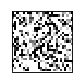

Iteration 5210000: loss=1.1772129937526188e-09 prediction=2
Iteration 5220000: loss=1.1764047513906917e-09 prediction=2
Iteration 5230000: loss=1.1756142725971586e-09 prediction=2
Iteration 5240000: loss=1.174822017446786e-09 prediction=2
Iteration 5250000: loss=1.1740386440806105e-09 prediction=2
Iteration 5260000: loss=1.1732694815691502e-09 prediction=2
Iteration 5270000: loss=1.172509200841887e-09 prediction=2
Iteration 5280000: loss=1.171768460039857e-09 prediction=2
Iteration 5290000: loss=1.1710419300925423e-09 prediction=2
Iteration 5300000: loss=1.170317176502067e-09 prediction=2


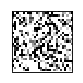

Iteration 5310000: loss=1.1695924229115917e-09 prediction=2
Iteration 5320000: loss=1.1688623402505982e-09 prediction=2
Iteration 5330000: loss=1.168137586660123e-09 prediction=2
Iteration 5340000: loss=1.1674163857833264e-09 prediction=2
Iteration 5350000: loss=1.1667022903338875e-09 prediction=2
Iteration 5360000: loss=1.1659491150339818e-09 prediction=2
Iteration 5370000: loss=1.1651906106635579e-09 prediction=2
Iteration 5380000: loss=1.164440988077331e-09 prediction=2
Iteration 5390000: loss=1.1636949182047829e-09 prediction=2
Iteration 5400000: loss=1.162954177402753e-09 prediction=2


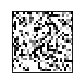

Iteration 5410000: loss=1.1622081075302049e-09 prediction=2
Iteration 5420000: loss=1.1614655903713356e-09 prediction=2
Iteration 5430000: loss=1.1607212968556269e-09 prediction=2
Iteration 5440000: loss=1.1599787796967576e-09 prediction=2
Iteration 5450000: loss=1.1592415916084065e-09 prediction=2
Iteration 5460000: loss=1.1585630232957556e-09 prediction=2
Iteration 5470000: loss=1.1578915604104623e-09 prediction=2
Iteration 5480000: loss=1.1572165448114902e-09 prediction=2
Iteration 5490000: loss=1.156514883859927e-09 prediction=2
Iteration 5500000: loss=1.1558274337630792e-09 prediction=2


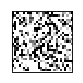

Iteration 5510000: loss=1.155161299948304e-09 prediction=2
Iteration 5520000: loss=1.154495166133529e-09 prediction=2
Iteration 5530000: loss=1.1538379141029509e-09 prediction=2
Iteration 5540000: loss=1.1531930965702486e-09 prediction=2
Iteration 5550000: loss=1.1525411736101887e-09 prediction=2
Iteration 5560000: loss=1.15188569793645e-09 prediction=2
Iteration 5570000: loss=1.1512213404785143e-09 prediction=2
Iteration 5580000: loss=1.1505516539500604e-09 prediction=2
Iteration 5590000: loss=1.149892625562643e-09 prediction=2
Iteration 5600000: loss=1.149231820818386e-09 prediction=2


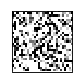

Iteration 5610000: loss=1.1485816742151655e-09 prediction=2
Iteration 5620000: loss=1.147940409396142e-09 prediction=2
Iteration 5630000: loss=1.147300920933958e-09 prediction=2
Iteration 5640000: loss=1.1466561034012557e-09 prediction=2
Iteration 5650000: loss=1.1460024040843564e-09 prediction=2
Iteration 5660000: loss=1.1453611392653329e-09 prediction=2
Iteration 5670000: loss=1.1447216508031488e-09 prediction=2
Iteration 5680000: loss=1.1440732805567677e-09 prediction=2
Iteration 5690000: loss=1.143435568451423e-09 prediction=2
Iteration 5700000: loss=1.1427925272755601e-09 prediction=2


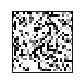

Iteration 5710000: loss=1.1421370516018214e-09 prediction=2
Iteration 5720000: loss=1.141478023214404e-09 prediction=2
Iteration 5730000: loss=1.1408225475406653e-09 prediction=2
Iteration 5740000: loss=1.140168848223766e-09 prediction=2
Iteration 5750000: loss=1.1395222543342243e-09 prediction=2
Iteration 5760000: loss=1.1388259224531794e-09 prediction=2
Iteration 5770000: loss=1.1380976161490253e-09 prediction=2
Iteration 5780000: loss=1.1373693098448712e-09 prediction=2
Iteration 5790000: loss=1.1366392271838777e-09 prediction=2
Iteration 5800000: loss=1.1358896045976508e-09 prediction=2


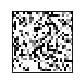

Iteration 5810000: loss=1.1351382056545845e-09 prediction=2
Iteration 5820000: loss=1.1343797012841605e-09 prediction=2
Iteration 5830000: loss=1.1336211969137366e-09 prediction=2
Iteration 5840000: loss=1.1328715743275097e-09 prediction=2
Iteration 5850000: loss=1.1321201753844434e-09 prediction=2
Iteration 5860000: loss=1.1313687764413771e-09 prediction=2
Iteration 5870000: loss=1.130613824784632e-09 prediction=2
Iteration 5880000: loss=1.1298624258415657e-09 prediction=2
Iteration 5890000: loss=1.12910925054166e-09 prediction=2
Iteration 5900000: loss=1.1283667333827907e-09 prediction=2


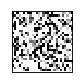

Iteration 5910000: loss=1.1276419797923154e-09 prediction=2
Iteration 5920000: loss=1.1269136734881613e-09 prediction=2
Iteration 5930000: loss=1.126188919897686e-09 prediction=2
Iteration 5940000: loss=1.125457060879853e-09 prediction=2
Iteration 5950000: loss=1.1248388886997418e-09 prediction=2
Iteration 5960000: loss=1.1242438091585427e-09 prediction=2
Iteration 5970000: loss=1.1236487296173436e-09 prediction=2
Iteration 5980000: loss=1.12303766286459e-09 prediction=2
Iteration 5990000: loss=1.1224248197549969e-09 prediction=2
Iteration 6000000: loss=1.1218048712180462e-09 prediction=2


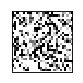

Iteration 6010000: loss=1.1211884753947743e-09 prediction=2
Iteration 6020000: loss=1.1205774086420206e-09 prediction=2
Iteration 6030000: loss=1.1199698946029457e-09 prediction=2
Iteration 6040000: loss=1.1193534987796738e-09 prediction=2
Iteration 6050000: loss=1.1187246684585261e-09 prediction=2
Iteration 6060000: loss=1.1180869563531814e-09 prediction=2
Iteration 6070000: loss=1.117454573318355e-09 prediction=2
Iteration 6080000: loss=1.1168186375698497e-09 prediction=2
Iteration 6090000: loss=1.1161880308918626e-09 prediction=2
Iteration 6100000: loss=1.1155165680065693e-09 prediction=2


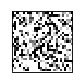

Iteration 6110000: loss=1.114845105121276e-09 prediction=2
Iteration 6120000: loss=1.114175418592822e-09 prediction=2
Iteration 6130000: loss=1.1135075084212076e-09 prediction=2
Iteration 6140000: loss=1.1128378218927537e-09 prediction=2
Iteration 6150000: loss=1.1122143206421242e-09 prediction=2
Iteration 6160000: loss=1.1115837139641371e-09 prediction=2
Iteration 6170000: loss=1.1109495545724712e-09 prediction=2
Iteration 6180000: loss=1.110286973471375e-09 prediction=2
Iteration 6190000: loss=1.1096208396565999e-09 prediction=2
Iteration 6200000: loss=1.1089653639828612e-09 prediction=2


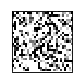

Iteration 6210000: loss=1.1083223228069983e-09 prediction=2
Iteration 6220000: loss=1.1076846107016536e-09 prediction=2
Iteration 6230000: loss=1.1070451222394695e-09 prediction=2
Iteration 6240000: loss=1.106412739204643e-09 prediction=2
Iteration 6250000: loss=1.1057252891077951e-09 prediction=2
Iteration 6260000: loss=1.1050200754425532e-09 prediction=2
Iteration 6270000: loss=1.104321967204669e-09 prediction=2
Iteration 6280000: loss=1.1036185298962664e-09 prediction=2
Iteration 6290000: loss=1.1029168689447033e-09 prediction=2
Iteration 6300000: loss=1.1022152079931402e-09 prediction=2


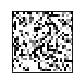

Iteration 6310000: loss=1.1015206524689347e-09 prediction=2
Iteration 6320000: loss=1.1008314260152474e-09 prediction=2
Iteration 6330000: loss=1.1001404232047207e-09 prediction=2
Iteration 6340000: loss=1.0994565258215516e-09 prediction=2
Iteration 6350000: loss=1.0987797338657401e-09 prediction=2
Iteration 6360000: loss=1.098140245403556e-09 prediction=2
Iteration 6370000: loss=1.0975131914392477e-09 prediction=2
Iteration 6380000: loss=1.0969305463959245e-09 prediction=2
Iteration 6390000: loss=1.0963745467051922e-09 prediction=2
Iteration 6400000: loss=1.0958220997281387e-09 prediction=2


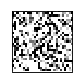

Iteration 6410000: loss=1.0952678763942458e-09 prediction=2
Iteration 6420000: loss=1.0947243112013894e-09 prediction=2
Iteration 6430000: loss=1.0941523242991025e-09 prediction=2
Iteration 6440000: loss=1.093582113753655e-09 prediction=2
Iteration 6450000: loss=1.0930101268513681e-09 prediction=2
Iteration 6460000: loss=1.0924292581648842e-09 prediction=2
Iteration 6470000: loss=1.0918501658352397e-09 prediction=2
Iteration 6480000: loss=1.0912675207919165e-09 prediction=2
Iteration 6490000: loss=1.0906902048191114e-09 prediction=2
Iteration 6500000: loss=1.0901075597757881e-09 prediction=2


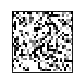

Iteration 6510000: loss=1.089530243802983e-09 prediction=2
Iteration 6520000: loss=1.088952927830178e-09 prediction=2
Iteration 6530000: loss=1.0883685064300153e-09 prediction=2
Iteration 6540000: loss=1.0877876377435314e-09 prediction=2
Iteration 6550000: loss=1.087204992700208e-09 prediction=2
Iteration 6560000: loss=1.0866241240137242e-09 prediction=2
Iteration 6570000: loss=1.0860450316840797e-09 prediction=2
Iteration 6580000: loss=1.0854641629975958e-09 prediction=2
Iteration 6590000: loss=1.084883294311112e-09 prediction=2
Iteration 6600000: loss=1.0843077546951463e-09 prediction=2


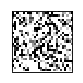

Iteration 6610000: loss=1.083742873220217e-09 prediction=2
Iteration 6620000: loss=1.0831904262431635e-09 prediction=2
Iteration 6630000: loss=1.0826415319797889e-09 prediction=2
Iteration 6640000: loss=1.0820944140732536e-09 prediction=2
Iteration 6650000: loss=1.0815472961667183e-09 prediction=2
Iteration 6660000: loss=1.0810019546170224e-09 prediction=2
Iteration 6670000: loss=1.0804601657810053e-09 prediction=2
Iteration 6680000: loss=1.079921929658667e-09 prediction=2
Iteration 6690000: loss=1.07938014082265e-09 prediction=2
Iteration 6700000: loss=1.0788454574139905e-09 prediction=2


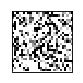

Iteration 6710000: loss=1.0783054449348128e-09 prediction=2
Iteration 6720000: loss=1.077768985169314e-09 prediction=2
Iteration 6730000: loss=1.077232525403815e-09 prediction=2
Iteration 6740000: loss=1.076690736567798e-09 prediction=2
Iteration 6750000: loss=1.0761560531591385e-09 prediction=2
Iteration 6760000: loss=1.0756195933936397e-09 prediction=2
Iteration 6770000: loss=1.0750813572713014e-09 prediction=2
Iteration 6780000: loss=1.0745520029331601e-09 prediction=2
Iteration 6790000: loss=1.0740155431676612e-09 prediction=2
Iteration 6800000: loss=1.0734826361158412e-09 prediction=2


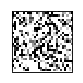

Iteration 6810000: loss=1.0729621635618969e-09 prediction=2
Iteration 6820000: loss=1.0724416910079526e-09 prediction=2
Iteration 6830000: loss=1.071919442097169e-09 prediction=2
Iteration 6840000: loss=1.0714078513274217e-09 prediction=2
Iteration 6850000: loss=1.070894484200835e-09 prediction=2
Iteration 6860000: loss=1.0703899988584453e-09 prediction=2
Iteration 6870000: loss=1.0698837371592163e-09 prediction=2
Iteration 6880000: loss=1.0693739227463084e-09 prediction=2
Iteration 6890000: loss=1.0688694374039187e-09 prediction=2
Iteration 6900000: loss=1.0683667284183684e-09 prediction=2


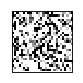

Iteration 6910000: loss=1.0678569140054606e-09 prediction=2
Iteration 6920000: loss=1.0673595340904285e-09 prediction=2
Iteration 6930000: loss=1.0668674832459146e-09 prediction=2
Iteration 6940000: loss=1.0663772087582402e-09 prediction=2
Iteration 6950000: loss=1.065888710627405e-09 prediction=2
Iteration 6960000: loss=1.0653984361397306e-09 prediction=2
Iteration 6970000: loss=1.064920596149932e-09 prediction=2
Iteration 6980000: loss=1.064455190658009e-09 prediction=2
Iteration 6990000: loss=1.0639862324524074e-09 prediction=2
Iteration 7000000: loss=1.0635172742468058e-09 prediction=2


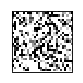

Iteration 7010000: loss=1.0630465396843647e-09 prediction=2
Iteration 7020000: loss=1.06258646326296e-09 prediction=2
Iteration 7030000: loss=1.0621175050573584e-09 prediction=2
Iteration 7040000: loss=1.0616538759222749e-09 prediction=2
Iteration 7050000: loss=1.0611760359324762e-09 prediction=2
Iteration 7060000: loss=1.060699972299517e-09 prediction=2
Iteration 7070000: loss=1.0602221323097183e-09 prediction=2
Iteration 7080000: loss=1.0597442923199196e-09 prediction=2
Iteration 7090000: loss=1.0592646759732816e-09 prediction=2
Iteration 7100000: loss=1.0587815069129647e-09 prediction=2


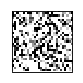

Iteration 7110000: loss=1.058303666923166e-09 prediction=2
Iteration 7120000: loss=1.0578542486427978e-09 prediction=2
Iteration 7130000: loss=1.0574083830761083e-09 prediction=2
Iteration 7140000: loss=1.0569625175094188e-09 prediction=2
Iteration 7150000: loss=1.0565184282995688e-09 prediction=2
Iteration 7160000: loss=1.0560743390897187e-09 prediction=2
Iteration 7170000: loss=1.0556266971661898e-09 prediction=2
Iteration 7180000: loss=1.0551826079563398e-09 prediction=2
Iteration 7190000: loss=1.0547385187464897e-09 prediction=2
Iteration 7200000: loss=1.0543015349639973e-09 prediction=2


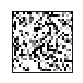

Iteration 7210000: loss=1.0538592221109866e-09 prediction=2
Iteration 7220000: loss=1.0534186856148153e-09 prediction=2
Iteration 7230000: loss=1.0529852545460017e-09 prediction=2
Iteration 7240000: loss=1.0525464944066698e-09 prediction=2
Iteration 7250000: loss=1.0521148396946955e-09 prediction=2
Iteration 7260000: loss=1.0516814086258819e-09 prediction=2
Iteration 7270000: loss=1.051251530270747e-09 prediction=2
Iteration 7280000: loss=1.0508269809861304e-09 prediction=2
Iteration 7290000: loss=1.0504024317015137e-09 prediction=2
Iteration 7300000: loss=1.049977882416897e-09 prediction=2


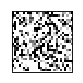

Iteration 7310000: loss=1.0495533331322804e-09 prediction=2
Iteration 7320000: loss=1.049125231133985e-09 prediction=2
Iteration 7330000: loss=1.04869535277885e-09 prediction=2
Iteration 7340000: loss=1.0482725798510728e-09 prediction=2
Iteration 7350000: loss=1.0478498069232955e-09 prediction=2
Iteration 7360000: loss=1.0474145994976425e-09 prediction=2
Iteration 7370000: loss=1.0469918265698652e-09 prediction=2
Iteration 7380000: loss=1.0465637245715698e-09 prediction=2
Iteration 7390000: loss=1.0461356225732743e-09 prediction=2
Iteration 7400000: loss=1.0457110732886576e-09 prediction=2


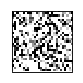

Iteration 7410000: loss=1.0452883003608804e-09 prediction=2
Iteration 7420000: loss=1.0448655274331031e-09 prediction=2
Iteration 7430000: loss=1.0444463072190047e-09 prediction=2
Iteration 7440000: loss=1.0440253106480668e-09 prediction=2
Iteration 7450000: loss=1.0436060904339683e-09 prediction=2
Iteration 7460000: loss=1.0431850938630305e-09 prediction=2
Iteration 7470000: loss=1.0427676500057714e-09 prediction=2
Iteration 7480000: loss=1.0423502061485124e-09 prediction=2
Iteration 7490000: loss=1.0419380913617715e-09 prediction=2
Iteration 7500000: loss=1.041536634716067e-09 prediction=2


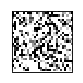

Iteration 7510000: loss=1.041110309074611e-09 prediction=2
Iteration 7520000: loss=1.0406857597899943e-09 prediction=2
Iteration 7530000: loss=1.0402576577916989e-09 prediction=2
Iteration 7540000: loss=1.039836661220761e-09 prediction=2
Iteration 7550000: loss=1.0394067828656262e-09 prediction=2
Iteration 7560000: loss=1.0389840099378489e-09 prediction=2
Iteration 7570000: loss=1.0385665660805898e-09 prediction=2
Iteration 7580000: loss=1.0381508985801702e-09 prediction=2
Iteration 7590000: loss=1.0377227965818747e-09 prediction=2
Iteration 7600000: loss=1.0373000236540975e-09 prediction=2


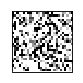

Iteration 7610000: loss=1.0368790270831596e-09 prediction=2
Iteration 7620000: loss=1.0364704650100975e-09 prediction=2
Iteration 7630000: loss=1.0360565738665173e-09 prediction=2
Iteration 7640000: loss=1.0356480117934552e-09 prediction=2
Iteration 7650000: loss=1.0352376733635538e-09 prediction=2
Iteration 7660000: loss=1.0348291112904917e-09 prediction=2
Iteration 7670000: loss=1.0344187728605903e-09 prediction=2
Iteration 7680000: loss=1.0340119871443676e-09 prediction=2
Iteration 7690000: loss=1.0336016487144661e-09 prediction=2
Iteration 7700000: loss=1.033193086641404e-09 prediction=2


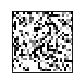

Iteration 7710000: loss=1.0327863009251814e-09 prediction=2
Iteration 7720000: loss=1.0323883969931558e-09 prediction=2
Iteration 7730000: loss=1.0319922694179695e-09 prediction=2
Iteration 7740000: loss=1.0315854837017469e-09 prediction=2
Iteration 7750000: loss=1.0311804743423636e-09 prediction=2
Iteration 7760000: loss=1.0307683595556227e-09 prediction=2
Iteration 7770000: loss=1.0303633501962395e-09 prediction=2
Iteration 7780000: loss=1.0299583408368562e-09 prediction=2
Iteration 7790000: loss=1.029553331477473e-09 prediction=2
Iteration 7800000: loss=1.0291589802591261e-09 prediction=2


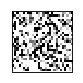

Iteration 7810000: loss=1.0287468654723853e-09 prediction=2
Iteration 7820000: loss=1.0283400797561626e-09 prediction=2
Iteration 7830000: loss=1.0279403994672975e-09 prediction=2
Iteration 7840000: loss=1.0275353901079143e-09 prediction=2
Iteration 7850000: loss=1.0271250516780128e-09 prediction=2
Iteration 7860000: loss=1.0267271477459872e-09 prediction=2
Iteration 7870000: loss=1.0263203620297645e-09 prediction=2
Iteration 7880000: loss=1.0259242344545783e-09 prediction=2
Iteration 7890000: loss=1.0255210014520344e-09 prediction=2
Iteration 7900000: loss=1.0251248738768481e-09 prediction=2


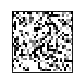

Iteration 7910000: loss=1.0247305226585013e-09 prediction=2
Iteration 7920000: loss=1.0243308423696362e-09 prediction=2
Iteration 7930000: loss=1.0239009640145014e-09 prediction=2
Iteration 7940000: loss=1.0234622038751695e-09 prediction=2
Iteration 7950000: loss=1.0230127855948012e-09 prediction=2
Iteration 7960000: loss=1.0225598146007542e-09 prediction=2
Iteration 7970000: loss=1.0221157253909041e-09 prediction=2
Iteration 7980000: loss=1.0216911761062875e-09 prediction=2
Iteration 7990000: loss=1.0212701795353496e-09 prediction=2
Iteration 8000000: loss=1.02085451203493e-09 prediction=2


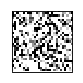

Iteration 8010000: loss=1.0204317391071527e-09 prediction=2
Iteration 8020000: loss=1.0200142952498936e-09 prediction=2
Iteration 8030000: loss=1.0195932986789558e-09 prediction=2
Iteration 8040000: loss=1.0191758548216967e-09 prediction=2
Iteration 8050000: loss=1.0187637400349558e-09 prediction=2
Iteration 8060000: loss=1.0183640597460908e-09 prediction=2
Iteration 8070000: loss=1.0179714848845833e-09 prediction=2
Iteration 8080000: loss=1.0175824627367547e-09 prediction=2
Iteration 8090000: loss=1.0171952169457654e-09 prediction=2
Iteration 8100000: loss=1.016811523868455e-09 prediction=2


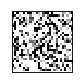

Iteration 8110000: loss=1.0164313835048233e-09 prediction=2
Iteration 8120000: loss=1.0160494667843523e-09 prediction=2
Iteration 8130000: loss=1.015662220993363e-09 prediction=2
Iteration 8140000: loss=1.0152660934181768e-09 prediction=2
Iteration 8150000: loss=1.0148717421998299e-09 prediction=2
Iteration 8160000: loss=1.0144809436951618e-09 prediction=2
Iteration 8170000: loss=1.0140883688336544e-09 prediction=2
Iteration 8180000: loss=1.0137028993995045e-09 prediction=2
Iteration 8190000: loss=1.0133263117495517e-09 prediction=2
Iteration 8200000: loss=1.0129443950290806e-09 prediction=2


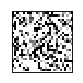

Iteration 8210000: loss=1.0125607019517702e-09 prediction=2
Iteration 8220000: loss=1.0121787852312991e-09 prediction=2
Iteration 8230000: loss=1.0118004212245069e-09 prediction=2
Iteration 8240000: loss=1.0114185045040358e-09 prediction=2
Iteration 8250000: loss=1.0110277059993678e-09 prediction=2
Iteration 8260000: loss=1.0106369074946997e-09 prediction=2
Iteration 8270000: loss=1.0102425562763528e-09 prediction=2
Iteration 8280000: loss=1.0098517577716848e-09 prediction=2
Iteration 8290000: loss=1.0094591829101773e-09 prediction=2
Iteration 8300000: loss=1.0090737134760275e-09 prediction=2


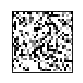

Iteration 8310000: loss=1.0086864676850382e-09 prediction=2
Iteration 8320000: loss=1.0082938928235308e-09 prediction=2
Iteration 8330000: loss=1.0079013179620233e-09 prediction=2
Iteration 8340000: loss=1.0075016376731583e-09 prediction=2
Iteration 8350000: loss=1.0070930756000962e-09 prediction=2
Iteration 8360000: loss=1.0066898425975523e-09 prediction=2
Iteration 8370000: loss=1.006284833238169e-09 prediction=2
Iteration 8380000: loss=1.0058887056629828e-09 prediction=2
Iteration 8390000: loss=1.0054979071583148e-09 prediction=2
Iteration 8400000: loss=1.005112437724165e-09 prediction=2


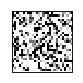

Iteration 8410000: loss=1.0047198628626575e-09 prediction=2
Iteration 8420000: loss=1.0043255116443106e-09 prediction=2
Iteration 8430000: loss=1.0039169495712486e-09 prediction=2
Iteration 8440000: loss=1.0035119402118653e-09 prediction=2
Iteration 8450000: loss=1.0030944963546062e-09 prediction=2
Iteration 8460000: loss=1.0026877106383836e-09 prediction=2
Iteration 8470000: loss=1.0022702667811245e-09 prediction=2
Iteration 8480000: loss=1.0018670337785807e-09 prediction=2
Iteration 8490000: loss=1.0014566953486792e-09 prediction=2
Iteration 8500000: loss=1.0010463569187777e-09 prediction=2


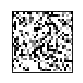

Iteration 8510000: loss=1.0006449002730733e-09 prediction=2
Iteration 8520000: loss=1.00023989091369e-09 prediction=2
Iteration 8530000: loss=9.998366579111462e-10 prediction=2
Iteration 8540000: loss=9.994352012654417e-10 prediction=2
Iteration 8550000: loss=9.990337446197373e-10 prediction=2
Iteration 8560000: loss=9.98628735260354e-10 prediction=2
Iteration 8570000: loss=9.982219495441313e-10 prediction=2
Iteration 8580000: loss=9.978222692552663e-10 prediction=2
Iteration 8590000: loss=9.974314707505982e-10 prediction=2
Iteration 8600000: loss=9.970406722459302e-10 prediction=2


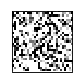

Iteration 8610000: loss=9.966516500981015e-10 prediction=2
Iteration 8620000: loss=9.962572988797547e-10 prediction=2
Iteration 8630000: loss=9.958665003750866e-10 prediction=2
Iteration 8640000: loss=9.954757018704186e-10 prediction=2
Iteration 8650000: loss=9.95068916154196e-10 prediction=2
Iteration 8660000: loss=9.946461432264186e-10 prediction=2
Iteration 8670000: loss=9.942286993691596e-10 prediction=2
Iteration 8680000: loss=9.938094791550611e-10 prediction=2
Iteration 8690000: loss=9.933902589409627e-10 prediction=2
Iteration 8700000: loss=9.929781441542218e-10 prediction=2


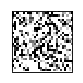

Iteration 8710000: loss=9.925624766538022e-10 prediction=2
Iteration 8720000: loss=9.921503618670613e-10 prediction=2
Iteration 8730000: loss=9.917204835119264e-10 prediction=2
Iteration 8740000: loss=9.91292381513631e-10 prediction=2
Iteration 8750000: loss=9.908678322290143e-10 prediction=2
Iteration 8760000: loss=9.904468356580765e-10 prediction=2
Iteration 8770000: loss=9.900222863734598e-10 prediction=2
Iteration 8780000: loss=9.895995134456825e-10 prediction=2
Iteration 8790000: loss=9.891838459452629e-10 prediction=2
Iteration 8800000: loss=9.887664020880038e-10 prediction=2


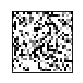

Iteration 8810000: loss=9.883471818739054e-10 prediction=2
Iteration 8820000: loss=9.879261853029675e-10 prediction=2
Iteration 8830000: loss=9.875051887320296e-10 prediction=2
Iteration 8840000: loss=9.870930739452888e-10 prediction=2
Iteration 8850000: loss=9.866756300880297e-10 prediction=2
Iteration 8860000: loss=9.862617389444495e-10 prediction=2
Iteration 8870000: loss=9.858478478008692e-10 prediction=2
Iteration 8880000: loss=9.854321803004495e-10 prediction=2
Iteration 8890000: loss=9.850165128000299e-10 prediction=2
Iteration 8900000: loss=9.846008452996102e-10 prediction=2


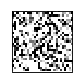

Iteration 8910000: loss=9.8418695415603e-10 prediction=2
Iteration 8920000: loss=9.837748393692891e-10 prediction=2
Iteration 8930000: loss=9.833591718688695e-10 prediction=2
Iteration 8940000: loss=9.829435043684498e-10 prediction=2
Iteration 8950000: loss=9.82531389581709e-10 prediction=2
Iteration 8960000: loss=9.821228275086469e-10 prediction=2
Iteration 8970000: loss=9.81719594506103e-10 prediction=2
Iteration 8980000: loss=9.813163615035592e-10 prediction=2
Iteration 8990000: loss=9.809184575715335e-10 prediction=2
Iteration 9000000: loss=9.805205536395079e-10 prediction=2


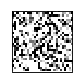

Iteration 9010000: loss=9.801226497074822e-10 prediction=2
Iteration 9020000: loss=9.797300748459747e-10 prediction=2
Iteration 9030000: loss=9.793392763413067e-10 prediction=2
Iteration 9040000: loss=9.789378196956022e-10 prediction=2
Iteration 9050000: loss=9.785399157635766e-10 prediction=2
Iteration 9060000: loss=9.781473409020691e-10 prediction=2
Iteration 9070000: loss=9.777494369700435e-10 prediction=2
Iteration 9080000: loss=9.773515330380178e-10 prediction=2
Iteration 9090000: loss=9.769589581765104e-10 prediction=2
Iteration 9100000: loss=9.765681596718423e-10 prediction=2


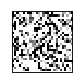

Iteration 9110000: loss=9.761738084534954e-10 prediction=2
Iteration 9120000: loss=9.75781233591988e-10 prediction=2
Iteration 9130000: loss=9.753957641578381e-10 prediction=2
Iteration 9140000: loss=9.750014129394913e-10 prediction=2
Iteration 9150000: loss=9.746070617211444e-10 prediction=2
Iteration 9160000: loss=9.74187841507046e-10 prediction=2
Iteration 9170000: loss=9.73775726720305e-10 prediction=2
Iteration 9180000: loss=9.73358282863046e-10 prediction=2
Iteration 9190000: loss=9.729461680763052e-10 prediction=2
Iteration 9200000: loss=9.72541158716922e-10 prediction=2


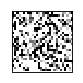

Iteration 9210000: loss=9.721272675733417e-10 prediction=2
Iteration 9220000: loss=9.717258109276372e-10 prediction=2
Iteration 9230000: loss=9.713136961408964e-10 prediction=2
Iteration 9240000: loss=9.709015813541555e-10 prediction=2
Iteration 9250000: loss=9.705285464178814e-10 prediction=2
Iteration 9260000: loss=9.701501824110892e-10 prediction=2
Iteration 9270000: loss=9.69780700188494e-10 prediction=2
Iteration 9280000: loss=9.694076652522199e-10 prediction=2
Iteration 9290000: loss=9.690381830296246e-10 prediction=2
Iteration 9300000: loss=9.686775825912264e-10 prediction=2


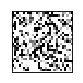

Iteration 9310000: loss=9.683169821528281e-10 prediction=2
Iteration 9320000: loss=9.679492762870723e-10 prediction=2
Iteration 9330000: loss=9.675815704213164e-10 prediction=2
Iteration 9340000: loss=9.672120881987212e-10 prediction=2
Iteration 9350000: loss=9.668461586898047e-10 prediction=2
Iteration 9360000: loss=9.6647490011037e-10 prediction=2
Iteration 9370000: loss=9.661036415309354e-10 prediction=2
Iteration 9380000: loss=9.657323829515008e-10 prediction=2
Iteration 9390000: loss=9.653629007289055e-10 prediction=2
Iteration 9400000: loss=9.649934185063103e-10 prediction=2


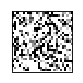

Iteration 9410000: loss=9.646257126405544e-10 prediction=2
Iteration 9420000: loss=9.64250901347441e-10 prediction=2
Iteration 9430000: loss=9.638441156312183e-10 prediction=2
Iteration 9440000: loss=9.634248954171198e-10 prediction=2
Iteration 9450000: loss=9.630074515598608e-10 prediction=2
Iteration 9460000: loss=9.625917840594411e-10 prediction=2
Iteration 9470000: loss=9.62183221986379e-10 prediction=2
Iteration 9480000: loss=9.6176577812912e-10 prediction=2
Iteration 9490000: loss=9.613536633423791e-10 prediction=2
Iteration 9500000: loss=9.6093621948512e-10 prediction=2


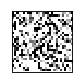

Iteration 9510000: loss=9.605169992710216e-10 prediction=2
Iteration 9520000: loss=9.600995554137626e-10 prediction=2
Iteration 9530000: loss=9.596963224112187e-10 prediction=2
Iteration 9540000: loss=9.593055239065507e-10 prediction=2
Iteration 9550000: loss=9.589129490450432e-10 prediction=2
Iteration 9560000: loss=9.585239268972146e-10 prediction=2
Iteration 9570000: loss=9.581384574630647e-10 prediction=2
Iteration 9580000: loss=9.577512116720754e-10 prediction=2
Iteration 9590000: loss=9.573604131674074e-10 prediction=2
Iteration 9600000: loss=9.569731673764181e-10 prediction=2


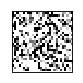

Iteration 9610000: loss=9.5658236887175e-10 prediction=2
Iteration 9620000: loss=9.561968994376002e-10 prediction=2
Iteration 9630000: loss=9.55809653646611e-10 prediction=2
Iteration 9640000: loss=9.554259605693005e-10 prediction=2
Iteration 9650000: loss=9.550404911351507e-10 prediction=2
Iteration 9660000: loss=9.54651468987322e-10 prediction=2
Iteration 9670000: loss=9.542748813373692e-10 prediction=2
Iteration 9680000: loss=9.5388763554638e-10 prediction=2
Iteration 9690000: loss=9.535057188259088e-10 prediction=2
Iteration 9700000: loss=9.531220257485984e-10 prediction=2


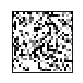

Iteration 9710000: loss=9.527418853849667e-10 prediction=2
Iteration 9720000: loss=9.523599686644957e-10 prediction=2
Iteration 9730000: loss=9.519744992303458e-10 prediction=2
Iteration 9740000: loss=9.515943588667142e-10 prediction=2
Iteration 9750000: loss=9.512177712167613e-10 prediction=2
Iteration 9760000: loss=9.508376308531297e-10 prediction=2
Iteration 9770000: loss=9.50457490489498e-10 prediction=2
Iteration 9780000: loss=9.500826791963846e-10 prediction=2
Iteration 9790000: loss=9.497078679032711e-10 prediction=2
Iteration 9800000: loss=9.49334832966997e-10 prediction=2


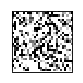

Iteration 9810000: loss=9.48961798030723e-10 prediction=2
Iteration 9820000: loss=9.486083030196824e-10 prediction=2
Iteration 9830000: loss=9.48251255294963e-10 prediction=2
Iteration 9840000: loss=9.478906548565647e-10 prediction=2
Iteration 9850000: loss=9.475265017044876e-10 prediction=2
Iteration 9860000: loss=9.471659012660893e-10 prediction=2
Iteration 9870000: loss=9.46814182611888e-10 prediction=2
Iteration 9880000: loss=9.464553585303292e-10 prediction=2
Iteration 9890000: loss=9.461018635192886e-10 prediction=2
Iteration 9900000: loss=9.457465921514085e-10 prediction=2


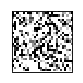

Iteration 9910000: loss=9.453913207835285e-10 prediction=2
Iteration 9920000: loss=9.45052036627203e-10 prediction=2
Iteration 9930000: loss=9.447269633255928e-10 prediction=2
Iteration 9940000: loss=9.444534043723252e-10 prediction=2
Iteration 9950000: loss=9.441709636348605e-10 prediction=2
Iteration 9960000: loss=9.438902992542353e-10 prediction=2
Iteration 9970000: loss=9.436043058030918e-10 prediction=2
Iteration 9980000: loss=9.433218650656272e-10 prediction=2
Iteration 9990000: loss=9.430394243281626e-10 prediction=2
Iteration 10000000: loss=9.42756983590698e-10 prediction=2


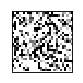

In [39]:
new_image_randn, loss_stats = generate_image(img, 2)

Сгенерированное изображение цифры "2"

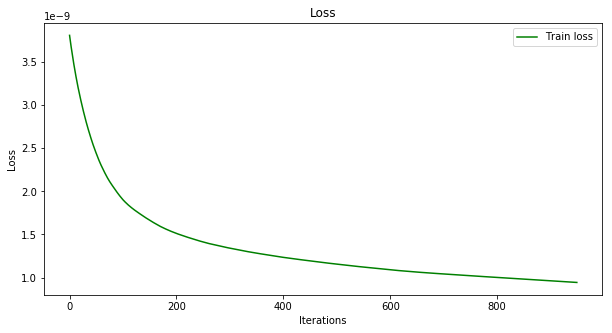

In [40]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Loss")
plt.plot(loss_stats[50:], color='green', label='Train loss')

ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.legend()
